## Men's World Cup 2022 - Simulation
#### Dataset from: https://www.kaggle.com/datasets/cashncarry/fifaworldranking

Here I run a simulation based on the ranking of all teams to draw the probabilities of the different teams winning the Men's World Cup. I calculated the probability to win the championship and how likely all teams are to get to the different phases of the World Cup.

Summary of results:

1) The Top 4 countries with more chance of wining the World Cup are:
    
    i) Brazil 19%
    
    ii) Belgium 16%
    
    iii) Argentina 10%
    
    iv) France 9%

2) The most likely Final is Brazil vs Belgium 6%

3) The Poisson stochastic model for goals can predict the FIFA formula for the expected outcome of a match.

4) There is a correlation between the initial Elo Rank and the outcome of the tournament. This means that the random placement of the teams didn't change much the odds of each team to win. This can be predicted by a simple 'Mean-Field' model using the match expected outcome formula from the FIFA Elo rating. At each round, the probability to advance is given by the outcome probability with respect to an 'average team', where each round the strenght of this 'average team' increases by the Half-normal distribution.

#### Limitations of the simulation:

The central part of the simulation is the method to predict the outcome of the match. The number of goals scored by each team is given by a Poisson process where the average number of goals is modelled by [see Ref. 1]:
$$\mu = e^{\alpha_0 + \alpha_1 \Delta Elo/400}$$
Here the constants $\alpha_0, \alpha_1$ were copied from Ref. 1 and compared to the expected formula for the match outcome used by FIFA [see Ref. 2,3,4]. I haven't implemented a linear model to calculate these constants.

Another important limitation of my model are the group tiebreaks where I haven't considered all the different levels one can have a tie. I only considered the ranking by number of points, net goals and total goals by the teams. This can cause small differences but I don't expect these to affect the results substantially.

The final aspect that I haven't implemented are the odds for penalties of every team. After the group stage, if the match is a draw the teams have a penalty shoot-out. Here I considered that the teams have probabilities to win the penalties proportional to their Elo's. I haven't checked if that is true historically so I suspect that might change the results slightly.

#### References:
1) https://eightyfivepoints.blogspot.com/2018/05/what-can-we-expect-from-21st-fifa-world.html

2) https://www.eloratings.net/

3) https://en.wikipedia.org/wiki/World_Football_Elo_Ratings

4) https://www.fifa.com/fifa-world-ranking/men?dateId=id13603

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Auxiliary functions
def date_ini_cup(year):
    '''Returns the exact date of the beggining of every cup after 1992'''
    if int(year) == 1994:
        return datetime(year=1994,month=6,day=17)
    if int(year) == 1998:
        return datetime(year=1998,month=6,day=10)
    if int(year) == 2002:
        return datetime(year=2002,month=5,day=31)
    if int(year) == 2006:
        return datetime(year=2006,month=6,day=9)
    if int(year) == 2010:
        return datetime(year=2010,month=6,day=11)
    if int(year) == 2014:
        return datetime(year=2014,month=6,day=12)
    if int(year) == 2018:
        return datetime(year=2018,month=6,day=14)
    if int(year) == 2022:
        return datetime(year=2022,month=11,day=20)

def df_up_to_date(df,dt):
    '''Returns the FIFA ranking dataset with the ranking of every country up to date DT'''
    return df[(df['rank_date'] <= dt) & (df['rank_date'].dt.year == dt.year)].sort_values('rank_date').drop_duplicates('country_full', keep='last').sort_values('rank')

def rank(t):
        t = dict(sorted(t.items(), key = lambda x:(x[1].points, x[1].net_g, x[1].tot_g), reverse=True))
        return t

def update_elo(t1,t2,g1,g2,W):
    K = 40
    if abs(g1-g2) <= 1:
        G = 1
    elif abs(g1-g2) == 2:
        G = 3/2
    else:
        G = (11+abs(g1-g2))/8
    We = 1/(10**(-(t1.elo-t2.elo)/400)+1)
    return K*G*(W-We)

class Team:
    def __init__(self,name,elo):
        self.name = name
        self.elo = int(elo)
        self.points = 0
        self.tot_g = 0
        self.net_g = 0
    
    def update(self,p,g1,g2,delo):
        if p == -1:
            self.points = -1
        else:
            self.points += p
        self.tot_g += g1
        self.net_g += g1-g2
        self.elo += delo

class Group:
    def __init__(self):
        self.teams = {}
    
    def __contains__(self,other):
        return other in self.teams

    def __str__(self):
        self.teams = rank(self.teams)
        str_group = "{:<15} {:<5} {:<5} {:<5}".format('Name','Points','Net Goals','Total Goals')+"\n"
        for k,v in self.teams.items():
            str_group +="{:<15} {:<5} {:<5} {:<5}".format(str(k),str(v.points),str(v.net_g),str(v.tot_g))+"\n"
        return str_group
    
    def __getitem__(self,item):
        return self.teams[item]
    
    def add_team(self,team):
        self.teams[team.name] = team
    
    def top2(self):
        self.teams = rank(self.teams)
        return list(self.teams.values())[0], list(self.teams.values())[1]

def score(teams,par,home):
    '''Number of goals each TEAMS score in the match'''
    b1,b2,b3 = par
    t1, t2 = teams
    elo1, elo2 = t1.elo, t2.elo
    home1 = (t1.name == home)
    home2 = (t2.name == home)
    mu1 = np.exp(b1+b2*(elo1-elo2)/400+b3*home1)
    mu2 = np.exp(b1+b2*(elo2-elo1)/400+b3*home2)
    g1 = np.random.poisson(mu1)
    g2 = np.random.poisson(mu2)
    return g1,g2

def match(teams,group=True):
    '''Compute the result of the match between TEAMS'''
    t1, t2 = teams
    g1,g2 = score(teams,par,home)
    if g1 > g2:
        t1.update(3,g1,g2,update_elo(t1,t2,g1,g2,1))
        t2.update(0,g2,g1,update_elo(t2,t1,g2,g1,0))
        if not group: return t1,t2
    elif g2 > g1:
        t1.update(0,g1,g2,update_elo(t1,t2,g1,g2,0))
        t2.update(3,g2,g1,update_elo(t2,t1,g2,g1,1))
        if not group: return t2,t1
    elif (group) & (g1 == g2):
        t1.update(1,g1,g2,update_elo(t1,t2,g1,g2,0.5))
        t2.update(1,g2,g1,update_elo(t2,t1,g2,g1,0.5))
    elif (g1 == g2):
        # Penalties
        p = np.random.rand()
        if p < t1.elo/(t1.elo+t2.elo):
            t1.update(1,g1,g2,update_elo(t1,t2,g1,g2,0.75))
            t2.update(1,g2,g1,update_elo(t2,t1,g2,g1,0.5))
            if not group: return t1,t2
        else:
            t1.update(1,g1,g2,update_elo(t1,t2,g1,g2,0.5))
            t2.update(1,g2,g1,update_elo(t2,t1,g2,g1,0.75))
            if not group: return t2,t1

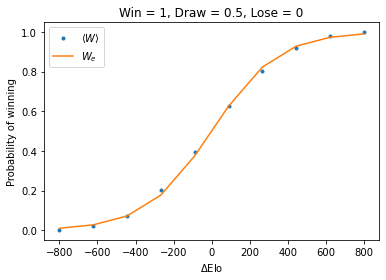

In [3]:
# Goals scored follows a Poisson distribution
par = [0.2, 4*0.21, 0.18]
home = "Russia"

# Comparison of Poisson distribution goal model and the expected result of match from FIFA Ranking
b1,b2,b3 = par
N = 1000
delo = np.linspace(-800, 800, 10)
W = np.zeros(len(delo))
We = np.zeros(len(delo))

for i in range(len(W)):
    for j in range(N):
        mu1 = np.exp(b1+b2*delo[i]/400)
        mu2 = np.exp(b1-b2*delo[i]/400)
        g1 = np.random.poisson(mu1)
        g2 = np.random.poisson(mu2)
        if g1 > g2: W[i] += 1
        if g1 == g2: W[i] += 0.5
    W[i] = W[i]/N
    We[i] = 1/(10**(-delo[i]/400)+1)

plt.plot(delo,W,'.',label=r'$\langle W \rangle$')
plt.plot(delo,We,label=r'$W_e$')
plt.title('Win = 1, Draw = 0.5, Lose = 0')
plt.xlabel(r'$\Delta$Elo')
plt.ylabel('Probability of winning')
plt.legend()

Most probable scenarios:
SF1: ['Brazil', 'Argentina'] 11 %
SF2: ['Belgium', 'France'] 9 %
Final: ['Brazil', 'Belgium'] 6 %


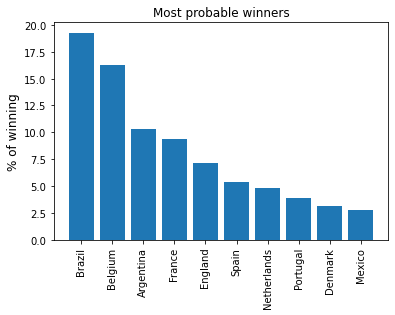

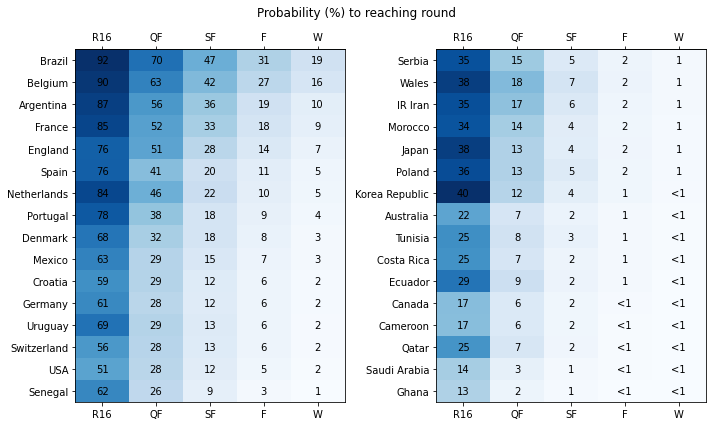

In [11]:
# FIFA Ranking from 1992-2022
df_rank_all = pd.read_csv('fifa_ranking-2022-10-06.csv')
df_rank_all['rank_date'] = pd.to_datetime(df_rank_all['rank_date'])

# World Cup 2022 Groups
df_w22_games = pd.read_csv('fifa_wcup22_groups.csv')
df_w22_games['Home Team'] = df_w22_games['Home Team'].apply(lambda x: 'IR Iran' if x == 'Iran' else x)
df_w22_games['Away Team'] = df_w22_games['Away Team'].apply(lambda x: 'IR Iran' if x == 'Iran' else x)
df_w22_games = df_w22_games[df_w22_games['Group'].notna()].drop(['Date','Location'],axis=1)

df_w22_rank = df_up_to_date(df_rank_all,date_ini_cup(2022)).drop(['rank_change','confederation','rank_date'],axis=1)
df_w22_rank = df_w22_rank.merge(df_w22_games[['Home Team','Group']].drop_duplicates(),how='left',left_on='country_full',right_on='Home Team')
df_w22_rank = df_w22_rank[df_w22_rank['Group'].notna()].drop(['Home Team'],axis=1).sort_values('Group')

# Statistics
# Here we run the simulation N = 1000 times and collect probabilities of events
N = 10000

winner = {x:0 for x in list(df_w22_rank['country_full'])}
how_far = {x:[0,0,0,0,0] for x in list(df_w22_rank['country_full'])}
sf1_prob = {}
sf2_prob = {}
sf_prob = {}
f_prob = {}

for i in range(N):
    # Groups
    groups = {}
    for index,row in df_w22_rank.iterrows():
        if not (row['Group'] in groups):
            groups[row['Group']] = Group()
        if not (row['country_full'] in groups[row['Group']]):
            groups[row['Group']].add_team(Team(row['country_full'],row['total_points']))

    # Group games
    for index,row in df_w22_games.iterrows():
        match([groups[row['Group']][row['Home Team']],groups[row['Group']][row['Away Team']]],group=True)

    # Round of 16
    r16 = {}
    for l in ["A","B","C","D","E","F","G","H"]:
        top2 = groups['Group '+l].top2()
        r16["1"+l] = top2[0]
        r16["2"+l] = top2[1]
    for k,v in r16.items():
        how_far[r16[k].name][0] += 1

    # Quarter-finals
    q8 = {}
    q8["1A/2B"] = match([r16["1A"],r16["2B"]],group=False)[0]
    q8["1C/2D"] = match([r16["1C"],r16["2D"]],group=False)[0]
    q8["1D/2C"] = match([r16["1D"],r16["2C"]],group=False)[0]
    q8["1B/2A"] = match([r16["1B"],r16["2A"]],group=False)[0]
    q8["1E/2F"] = match([r16["1E"],r16["2F"]],group=False)[0]
    q8["1G/2H"] = match([r16["1G"],r16["2H"]],group=False)[0]
    q8["1F/2E"] = match([r16["1F"],r16["2E"]],group=False)[0]
    q8["1H/2G"] = match([r16["1H"],r16["2G"]],group=False)[0]
    for k,v in q8.items():
        how_far[q8[k].name][1] += 1

    # Semi-finals
    sf = {}
    sf["QF1"] = match([q8["1E/2F"],q8["1G/2H"]],group=False)[0]
    sf["QF2"] = match([q8["1A/2B"],q8["1C/2D"]],group=False)[0]
    sf["QF3"] = match([q8["1F/2E"],q8["1H/2G"]],group=False)[0]
    sf["QF4"] = match([q8["1B/2A"],q8["1D/2C"]],group=False)[0]
    for k,v in sf.items():
        how_far[sf[k].name][2] += 1

    # Final
    final = {}
    final2 = {}
    final["SF1"],final2["L1"] = match([sf["QF1"],sf["QF2"]],group=False)
    final["SF2"],final2["L2"] = match([sf["QF3"],sf["QF4"]],group=False)
    for k,v in final.items():
        how_far[final[k].name][3] += 1

    # Winners
    first,second = match([final["SF1"],final["SF2"]],group=False)
    third,fourth = match([final2["L1"],final2["L2"]],group=False)
    
    how_far[first.name][4] += 1
    winner[first.name] += 1

    # Most likely scenarios
    names = list(df_w22_rank['country_full'])
    s1 = str(names.index(sf['QF1'].name)) + '.' + str(names.index(sf['QF2'].name))
    s2 = str(names.index(sf['QF3'].name)) + '.' + str(names.index(sf['QF4'].name))
    s = s1 + '.' + s2
    f = str(names.index(final['SF1'].name)) + '.' + str(names.index(final['SF2'].name))
    if s1 in sf1_prob:
        sf1_prob[s1] += 1
    else:
        sf1_prob[s1] = 1
    if s2 in sf2_prob:
        sf2_prob[s2] += 1
    else:
        sf2_prob[s2] = 1
    if s in sf_prob:
        sf_prob[s] += 1
    else:
        sf_prob[s] = 1
    if f in f_prob:
        f_prob[f] += 1
    else:
        f_prob[f] = 1

# Plotting results
# Most likely scenarios
sf1_prob = dict(sorted(sf1_prob.items(), key=lambda item: item[1], reverse=True))
sf2_prob = dict(sorted(sf2_prob.items(), key=lambda item: item[1], reverse=True))
sf_prob = dict(sorted(sf_prob.items(), key=lambda item: item[1], reverse=True))
f_prob = dict(sorted(f_prob.items(), key=lambda item: item[1], reverse=True))
print('Most probable scenarios:')
print('SF1: ',end='')
print([names[int(x)] for x in list(sf1_prob.keys())[0].split('.')],end=' ')
print('{:.0f} %'.format(list(sf1_prob.values())[0]*100/N))
print('SF2: ',end='')
print([names[int(x)] for x in list(sf2_prob.keys())[0].split('.')],end=' ')
print('{:.0f} %'.format(list(sf2_prob.values())[0]*100/N))
print('Final: ',end='')
print([names[int(x)] for x in list(f_prob.keys())[0].split('.')],end=' ')
print('{:.0f} %'.format(list(f_prob.values())[0]*100/N))

# % of winning
winner = dict(sorted(winner.items(), key=lambda item: item[1], reverse=True))
plt.bar(list(winner.keys())[:10], np.array(list(winner.values()))[:10]*100/N)
plt.title('Most probable winners')
plt.ylabel('% of winning',fontsize=12)
plt.xticks(rotation=90)
plt.savefig('results/most_probable_winner.png',bbox_inches='tight')

# How far each country will go in the tournament
how_far = dict(sorted(how_far.items(), key=lambda x:(x[1][4],x[1][3],x[1][2],x[1][1],x[1][0]),reverse=True))
fig = plt.figure(figsize=(10,6))
ax = fig.subplots(nrows=1, ncols=2)
ax[0].imshow(np.array(list(how_far.values()))[0:16]*100/N, cmap='Blues', aspect='auto')
ax[0].set_yticks([i for i in range(16)])
ax[0].set_yticklabels(list(how_far.keys())[0:16])
ax[0].set_xticks([0,1,2,3,4])
ax[0].set_xticklabels(['R16','QF','SF','F','W'])
ax0_t = ax[0].secondary_xaxis('top')
ax0_t.set_xticks([0,1,2,3,4])
ax0_t.set_xticklabels(['R16','QF','SF','F','W'])
for (j,i), label in np.ndenumerate(np.array(list(how_far.values()))[0:16]*100/N):
    if float(label) > 0.5:
        ax[0].text(i,j,f'{label:.0f}',ha='center',va='center')
    elif float(label) > 0:
        ax[0].text(i,j,'<1',ha='center',va='center')
    else:
        ax[0].text(i,j,f'{label:.0f}',ha='center',va='center')

ax[1].imshow(np.array(list(how_far.values()))[16:32]*100/N, cmap='Blues', aspect='auto')
ax[1].set_yticks([i for i in range(16)])
ax[1].set_yticklabels(list(how_far.keys())[16:32])
ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels(['R16','QF','SF','F','W'])
ax1_t = ax[1].secondary_xaxis('top')
ax1_t.set_xticks([0,1,2,3,4])
ax1_t.set_xticklabels(['R16','QF','SF','F','W'])
for (j,i), label in np.ndenumerate(np.array(list(how_far.values()))[16:32]*100/N):
    if float(label) > 0.5:
        ax[1].text(i,j,f'{label:.0f}',ha='center',va='center')
    elif float(label) > 0:
        ax[1].text(i,j,'<1',ha='center',va='center')
    else:
        ax[1].text(i,j,f'{label:.0f}',ha='center',va='center')
fig.suptitle('Probability (%) to reaching round')
fig.tight_layout()
fig.subplots_adjust(top=.88)
fig.savefig('results/how_far_country.png',bbox_inches='tight')

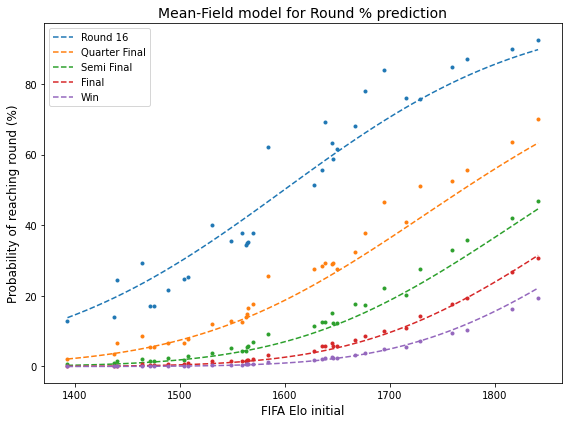

In [12]:
# Mean-Field approximation to calculate the odds for a team to reach round
# The probability to reach the R16 round is roughly the probability to get at least two wins in the group stage
# After each round, the average strenght of the remaining teams increase by the average of the Half-normal distribution
how_far_elo = {}
for index,row in df_w22_rank.iterrows():
    how_far_elo[row['country_full']] = [row['total_points']] + how_far[row['country_full']]

# FIFA Elo rating prediction
def prob_win(mean_elo):
    delta_elo = np.linspace(min([v[0] for v in list(how_far_elo.values())])-mean_elo, max([v[0] for v in list(how_far_elo.values())])-mean_elo, 50)
    We = 1/(10**(-delta_elo/400)+1)
    return We, delta_elo

plt.figure(figsize=(8,6))
# Round16 vs Elo rating
mean_elo = np.mean([v[0] for v in list(how_far_elo.values())])
We, delta_elo = prob_win(mean_elo)
prob16 = 3*(1-We)*We*We + We**3
#plt.figure()
plt.plot([v[0] for v in list(how_far_elo.values())], [v[1]*100/N for v in list(how_far_elo.values())], '.', color='C0')
plt.plot(delta_elo+mean_elo, prob16*100, '--', color='C0', label='Round 16')

# Quarter Final vs Elo rating
std_elo = np.std([v[0] for v in list(how_far_elo.values())])
mean_elo = np.mean([v[0] for v in list(how_far_elo.values())]) + std_elo*np.sqrt(2/np.pi)
We, delta_elo = prob_win(mean_elo)
prob8 = prob16*We
#plt.figure()
plt.plot([v[0] for v in list(how_far_elo.values())], [v[2]*100/N for v in list(how_far_elo.values())], '.', color='C1')
plt.plot(delta_elo+mean_elo, prob8*100, '--', color='C1', label='Quarter Final')

# Semi Final vs Elo rating
std_elo = np.std([v[0] for v in list(how_far_elo.values())])
mean_elo = np.mean([v[0] for v in list(how_far_elo.values())]) + std_elo*np.sqrt(2/np.pi)
We, delta_elo = prob_win(mean_elo)
prob4 = prob8*We
#plt.figure()
plt.plot([v[0] for v in list(how_far_elo.values())], [v[3]*100/N for v in list(how_far_elo.values())], '.', color='C2')
plt.plot(delta_elo+mean_elo, prob4*100, '--', color='C2', label='Semi Final')

# Final vs Elo rating
std_elo = np.std([v[0] for v in list(how_far_elo.values())])
mean_elo = np.mean([v[0] for v in list(how_far_elo.values())]) + std_elo*np.sqrt(2/np.pi)
We, delta_elo = prob_win(mean_elo)
prob2 = prob4*We
#plt.figure()
plt.plot([v[0] for v in list(how_far_elo.values())], [v[4]*100/N for v in list(how_far_elo.values())], '.', color='C3')
plt.plot(delta_elo+mean_elo, prob2*100, '--', color='C3', label='Final')

# Win vs Elo rating
std_elo = np.std([v[0] for v in list(how_far_elo.values())])
mean_elo = np.mean([v[0] for v in list(how_far_elo.values())]) + std_elo*np.sqrt(2/np.pi)
We, delta_elo = prob_win(mean_elo)
prob1 = prob2*We
#plt.figure()
plt.plot([v[0] for v in list(how_far_elo.values())], [v[5]*100/N for v in list(how_far_elo.values())], '.', color='C4')
plt.plot(delta_elo+mean_elo, prob1*100, '--', color='C4', label='Win')

plt.legend(loc='upper left')
plt.title('Mean-Field model for Round % prediction', fontsize=14)
plt.xlabel('FIFA Elo initial', fontsize=12)
plt.ylabel('Probability of reaching round (%)', fontsize=12)
plt.tight_layout()
plt.savefig('results/mean_field_model.png',bbox_inches='tight')